In [95]:
import os
import numpy as np
import tifffile as tiff
from skimage import io, morphology
import matplotlib.pyplot as plt
import warnings
import pathlib
from joblib import Parallel, delayed

warnings.filterwarnings("ignore", category=UserWarning)

############################################################################ INPUT CONFIG PARAMETERS
# Choose the dataset you want to process or add your own by configuring the following:
# n_res: The resolution, either 20 or 40.
# raw_input_sides: A list of patch sizes in ascending order, with the largest (original) size as the last entry.
#                  The script will divide the original image into patches and save them in the respective folders.
# writefolds: Set to 1 to generate a file with fold information, or 0 to skip this step.
# displayflag: Set to 1 to display the processing results.
# validImages: A list of validation images (labeled as 1 in folds.csv). If left empty, all images will be set to train (labeled as 0). 
#              You can modify this later in the output .csv.
# testImages: A list of test images (labeled as 2 in folds.csv). If left empty, all images will be set to train (labeled as 0).
#             You can modify this later in the output .csv.

###################################### Conic

# root_folder_dataset = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","conic")
# outputfolder = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","conic")
# n_res = 20;
# raw_input_sides = [256];
# writefolds = 0;
# displayflag = 0;

###################################### Pannuke

# root_folder_dataset = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","pannuke")
# outputfolder = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","pannuke")
# n_res = 40
# raw_input_sides = [256]
# writefolds = 0
# displayflag = 0

###################################### cytodark0
root_folder_dataset = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","cytodark0")
outputfolder = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","cytodark0")

n_res = 20
raw_input_sides = [256, 512, 1024]
writefolds = 1
displayflag = 0

# n_res = 40
# raw_input_sides = [256, 512, 1024, 2048]
# writefolds = 1
# displayflag = 0

# Define valid images (this is an example, not the full set of validaton images for cytodark0)
validImages = ["ID11_Aud_Cortex_Tursiops"]

# Define test images (this is an example, not the full set of test images for cytodark0)
testImages = ["ID12_Aud_Cortex_Tursiops"]

###################################### MoNuSegTestData
# root_folder_dataset = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","monusegtestdata")
# outputfolder = os.path.join(pathlib.Path(os.getcwd()).parents[1],"datasets","monusegtestdata")
# n_res = 40
# raw_input_sides = [1024]
# writefolds = 1
# displayflag = 0
# validImages = []
# testImages = []

##################################################################################################################

# Setting other parameters
resolution_folder = f"{n_res}x"

if writefolds == 1:
    folds = [[("img_id", "fold")] for _ in range(len(raw_input_sides))]

raw_input_side = raw_input_sides[-1]
largest_size = raw_input_sides[-1]

# Path to instance labels and raw images
root_folder_mk = os.path.join(
    root_folder_dataset,
    resolution_folder,
    f"{raw_input_side}x{raw_input_side}",
    "label",
)
root_folder_raw = os.path.join(
    root_folder_dataset,
    resolution_folder,
    f"{raw_input_side}x{raw_input_side}",
    "image",
)

# Reading images from folder
ict_names = [
    os.path.splitext(f)[0] for f in os.listdir(root_folder_raw) if f.endswith(".png")
]


for ict_name in ict_names[0:3]:
    print(f"Processing {ict_name}")

    if writefolds == 1:
        fold = 0
        if any(ict_name.startswith(v) for v in validImages):
            fold = 1
        elif any(ict_name.startswith(t) for t in testImages):
            fold = 2

    # Load the RGB image
    rgbimagecrop = io.imread(os.path.join(root_folder_raw, ict_name + ".png"))
    image_size = rgbimagecrop.shape

    # Load the labels
    labelsnewall = tiff.imread(os.path.join(root_folder_mk, ict_name + ".tiff"))

    matlab_strel_disk_2 = np.array(
        [
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
            [0, 0, 1, 0, 0],
        ]
    ).astype(np.uint8)

    matlab_strel_disk_3 = np.ones([5, 5]).astype(np.uint8)

    matlab_strel_disk_5 = np.array(
        [
            [0, 0, 1, 1, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0],
        ]
    ).astype(np.uint8)

    matlab_strel_disk_6 = np.array(
        [
            [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        ]
    ).astype(np.uint8)

    if n_res == 20:
        segap = matlab_strel_disk_3
        secellbodydil = morphology.square(3)
        secellbodydillarger = matlab_strel_disk_3
        seerode = morphology.square(3)
        se4 = morphology.square(3)
        se2 = morphology.disk(1)
        minsize1 = 2
        minsize2 = 4
        maxsizeholes = 3
        erosionstrel = morphology.square(3)
    else:
        segap = matlab_strel_disk_5
        secellbodydil = matlab_strel_disk_2
        secellbodydillarger = matlab_strel_disk_6
        seerode = matlab_strel_disk_3
        se4 = matlab_strel_disk_2
        se2 = morphology.square(3)
        minsize1 = 6
        minsize2 = 11
        maxsizeholes = 8
        erosionstrel = morphology.square(5)

    mapping = np.ones_like(labelsnewall)  # was 1 in the paper - cell
    J = morphology.black_tophat(labelsnewall, footprint=segap) > 0
    mapping[(labelsnewall == 0) & (J == 0)] = 2  # was 0 in the paper - background
    gap = (labelsnewall == 0) & (J > 0)

    mapping[gap > 0] = 3  # was 3 in the paper - gap
    gapwoutholes = (
        ~morphology.remove_small_holes(~gap, maxsizeholes, connectivity=4)
    ) & (mapping == 2)
    mapping[gapwoutholes > 0] = 3  # was 3 in the paper - gap

    if displayflag == 1:
        plt.figure()
        plt.imshow(mapping, cmap="gray")
        plt.show()

    touchingbodies = np.zeros_like(labelsnewall)
    touchingbodieslarger = np.zeros_like(labelsnewall)

    # for j in range(1, labelsnewall.max() + 1):
    #     cellbody = (labelsnewall == j).astype(np.uint8)
    #     touchingbodies += morphology.dilation(cellbody, secellbodydil)
    #     touchingbodieslarger += morphology.dilation(cellbody, secellbodydillarger)

    # Define the dilation function for parallel execution
    def dilate_label(j):
        cellbody = (labelsnewall == j).astype(np.uint8)
        touchingbodies_j = morphology.dilation(cellbody, secellbodydil)
        touchingbodieslarger_j = morphology.dilation(cellbody, secellbodydillarger)
        return touchingbodies_j, touchingbodieslarger_j

    # Get unique labels to process
    labels = np.unique(labelsnewall)[1:]  # Exclude label 0 if it's background

    # Run parallelized dilations
    results = Parallel(n_jobs=-1)(delayed(dilate_label)(j) for j in labels)

    # Aggregate the results
    touchingbodies = np.zeros_like(labelsnewall, dtype=np.uint8)
    touchingbodieslarger = np.zeros_like(labelsnewall, dtype=np.uint8)

    for tb, tbl in results:
        touchingbodies += tb
        touchingbodieslarger += tbl

    K = (touchingbodies > 1) & (labelsnewall > 0)
    Klarger = (touchingbodieslarger > 1) & (labelsnewall > 0)
    Kwoutholes = morphology.remove_small_holes(K, maxsizeholes, connectivity=1)
    Kwoutholeslarger = morphology.remove_small_holes(
        Klarger, maxsizeholes, connectivity=1
    )

    Kwoutholessmall = Kwoutholes ^ morphology.remove_small_objects(
        Kwoutholes * (labelsnewall > 0), minsize1, connectivity=1
    )
    Kwoutholessmall = morphology.dilation(Kwoutholessmall, se4) * (labelsnewall > 0)
    Kwoutholes = (Kwoutholes + Kwoutholessmall) > 0
    Kwoutholes = morphology.remove_small_holes(Kwoutholes, maxsizeholes, connectivity=1)

    Kwoutholessmall = Kwoutholes ^ morphology.remove_small_objects(
        Kwoutholes * (labelsnewall > 0), minsize2, connectivity=1
    )
    Kwoutholessmall = morphology.dilation(Kwoutholessmall, se2) * (labelsnewall > 0)

    Kwoutholes = (Kwoutholes + Kwoutholessmall) > 0
    Kwoutholes = morphology.remove_small_holes(Kwoutholes, maxsizeholes, connectivity=1)

    mapping[Kwoutholes > 0] = 0  # was 2 in the paper - touching
    mapping[
        (
            Kwoutholeslarger
            - morphology.reconstruction(
                morphology.erosion(Kwoutholeslarger, seerode), Kwoutholeslarger
            )
        )
        > 0
    ] = 0

    mapping[
        (mapping == 3)
        & (morphology.remove_small_objects((mapping == 3), 3, connectivity=1) == 0)
        & (morphology.dilation((mapping == 0), secellbodydil) > 0)
    ] = 0

    mapping[
        (mapping == 1)
        & (morphology.remove_small_objects((mapping == 1), 2, connectivity=1) == 0)
        & (morphology.dilation((mapping == 0), secellbodydil) > 0)
    ] = 0

    singles = (mapping == 0) ^ morphology.remove_small_objects(
        (mapping == 0), 2, connectivity=2
    )
    mapping[singles > 0] = 1

    if displayflag == 1:
        plt.figure()
        plt.imshow(mapping, cmap="gray")
        plt.show()

    io.imsave(
        os.path.join(
            outputfolder,
            resolution_folder,
            f"{raw_input_side}x{raw_input_side}",
            "graymask4",
            ict_name + ".png",
        ),
        mapping.astype(np.uint8),
    )

    if writefolds == 1 or len(raw_input_sides) > 1:
        for resi, raw_input_side in enumerate(raw_input_sides):
            patchSz = (raw_input_side, raw_input_side)
            xIdxs = np.arange(0, image_size[1] + 1, patchSz[1])
            yIdxs = np.arange(0, image_size[0] + 1, patchSz[0])

            patchesmapping = [
                [None for _ in range(len(xIdxs) - 1)] for _ in range(len(yIdxs) - 1)
            ]

            idx = 1
            for s in range(len(yIdxs) - 1):
                starty, endy = yIdxs[s], yIdxs[s + 1] - 1
                if endy - starty + 1 < raw_input_side:
                    starty = endy - raw_input_side + 1

                mappingsub = mapping[starty:endy, :]

                for k in range(len(xIdxs) - 1):
                    startx, endx = xIdxs[k], xIdxs[k + 1] - 1
                    if endx - startx + 1 < raw_input_side:
                        startx = endx - raw_input_side + 1

                    patchesmapping[s][k] = mappingsub[:, startx:endx]

                    if raw_input_side < largest_size:
                        io.imsave(
                            os.path.join(
                                outputfolder,
                                resolution_folder,
                                f"{raw_input_side}x{raw_input_side}",
                                "graymask4",
                                f"{ict_name}_{idx}.png",
                            ),
                            patchesmapping[s][k].astype(np.uint8),
                        )

                    img_id = (
                        f"{ict_name}_{idx}"
                        if raw_input_side < largest_size
                        else ict_name
                    )
                    if writefolds == 1:
                        folds[resi].append((img_id, fold))
                    idx += 1

# Saving lists of image names and corresponding fold for each image size
if writefolds == 1:
    for resi, raw_input_side in enumerate(raw_input_sides):
        np.savetxt(
            os.path.join(
                outputfolder,
                resolution_folder,
                f"{raw_input_side}x{raw_input_side}",
                "folds.csv",
            ),
            folds[resi],
            delimiter=",",
            fmt="%s",
        )

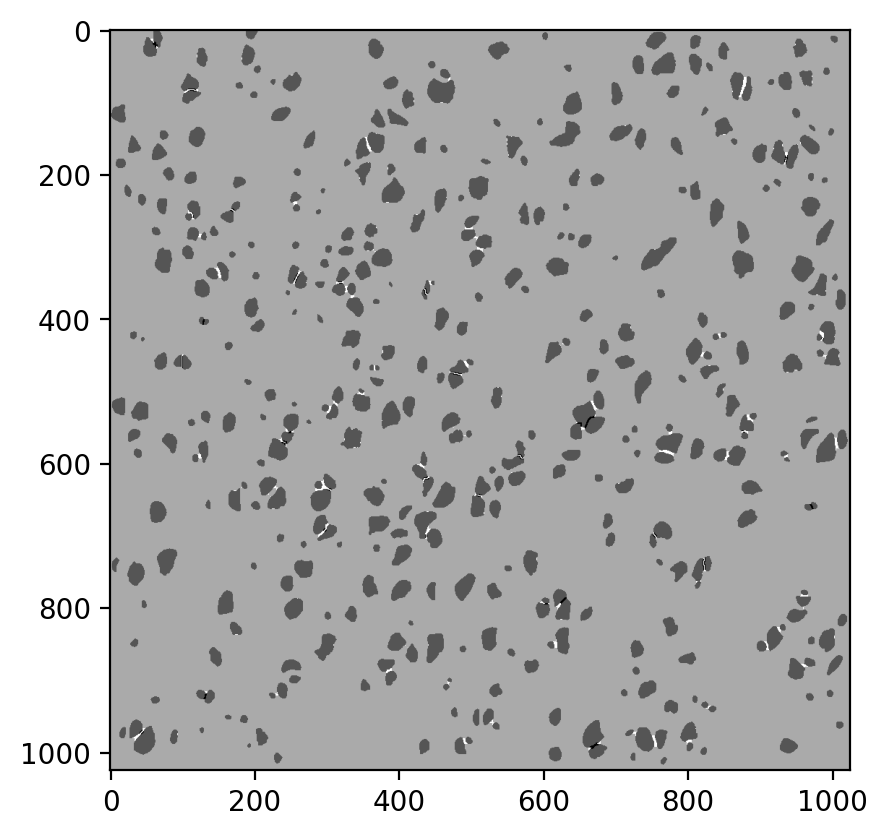

In [98]:
plt.figure(dpi=200)
plt.imshow(mapping, cmap="gray")